In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Αυτό το σύνολο δεδομένων περιέχει παρατηρήσεις καθημερινών καιρικών συνθηκών από πολλές περιοχές της Αυστραλίας για περίπου 10 χρόνια. Η στήλη RainTomorrow είναι η στοχευόμενη μεταβλητή που προσπαθούμε να προβλέψουμε. Αυτή η στήλη δείχνει αν θα βρέξει την επόμενη μέρα, με την τιμή "Yes" να σημαίνει ότι η βροχή για εκείνη τη μέρα ήταν 1mm ή περισσότερο.

Στόχος:
Ο στόχος είναι να προβλέψουμε αν θα βρέξει την επόμενη μέρα (RainTomorrow), χρησιμοποιώντας τις καιρικές παρατηρήσεις για κάθε ημέρα από τα δεδομένα. Ο χρήστης καλείται να αναπτύξει ένα μοντέλο μηχανικής μάθησης που θα μπορεί να προβλέψει την RainTomorrow βασιζόμενο στις άλλες καιρικές παραμέτρους, όπως θερμοκρασία, ταχύτητα ανέμου, υγρασία, κλπ.



**Bήμα 1: Εισαγωγή βιβλιοθηκών και φόρτωση δεδομένων**
*****

In [18]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [21]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warning messages

import pandas as pd
data = pd.read_csv('../input/weather-dataset-rattle-package/weatherAUS.csv', parse_dates=['Date'])


In [22]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

<Axes: >

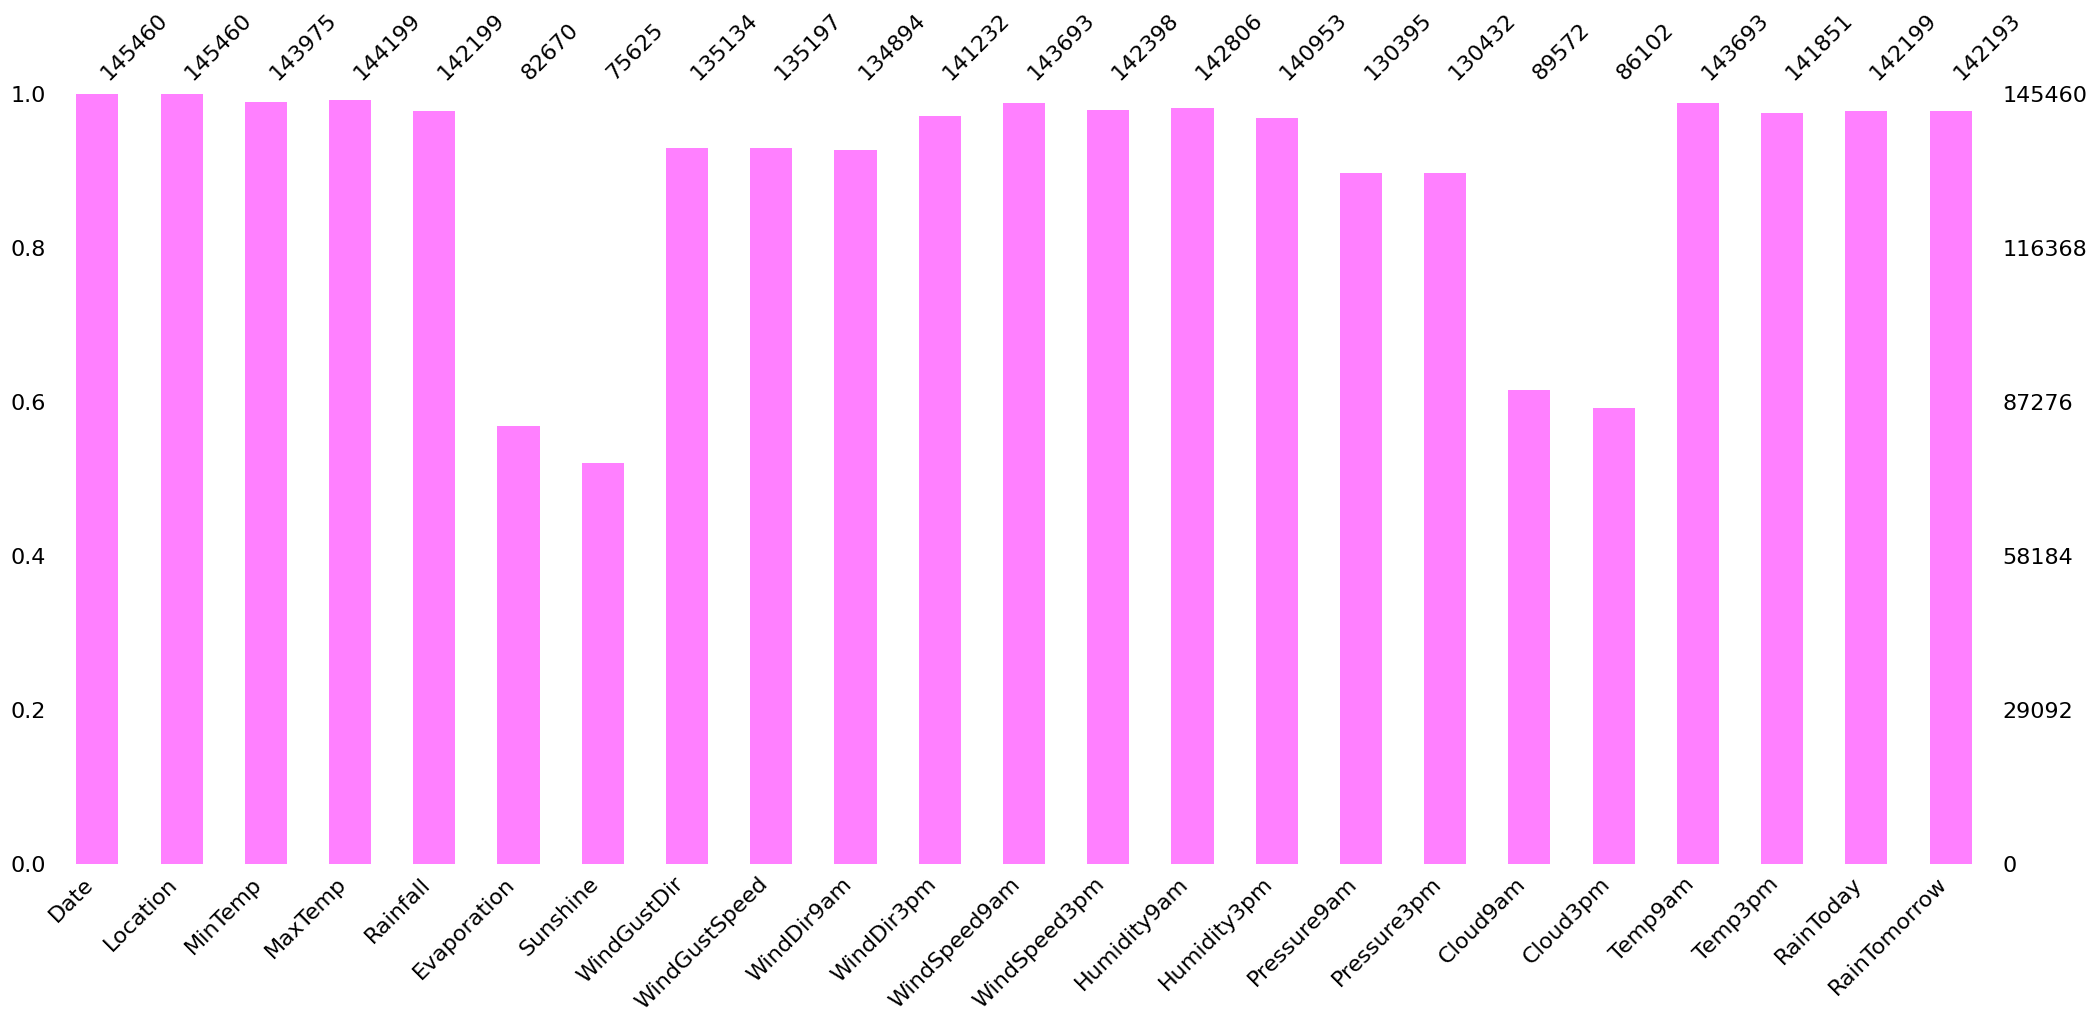

In [27]:
msno.bar(data,color='#ff80ff')
#plot

In [28]:
data.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm','Location'],axis=1,inplace=True)

<Axes: >

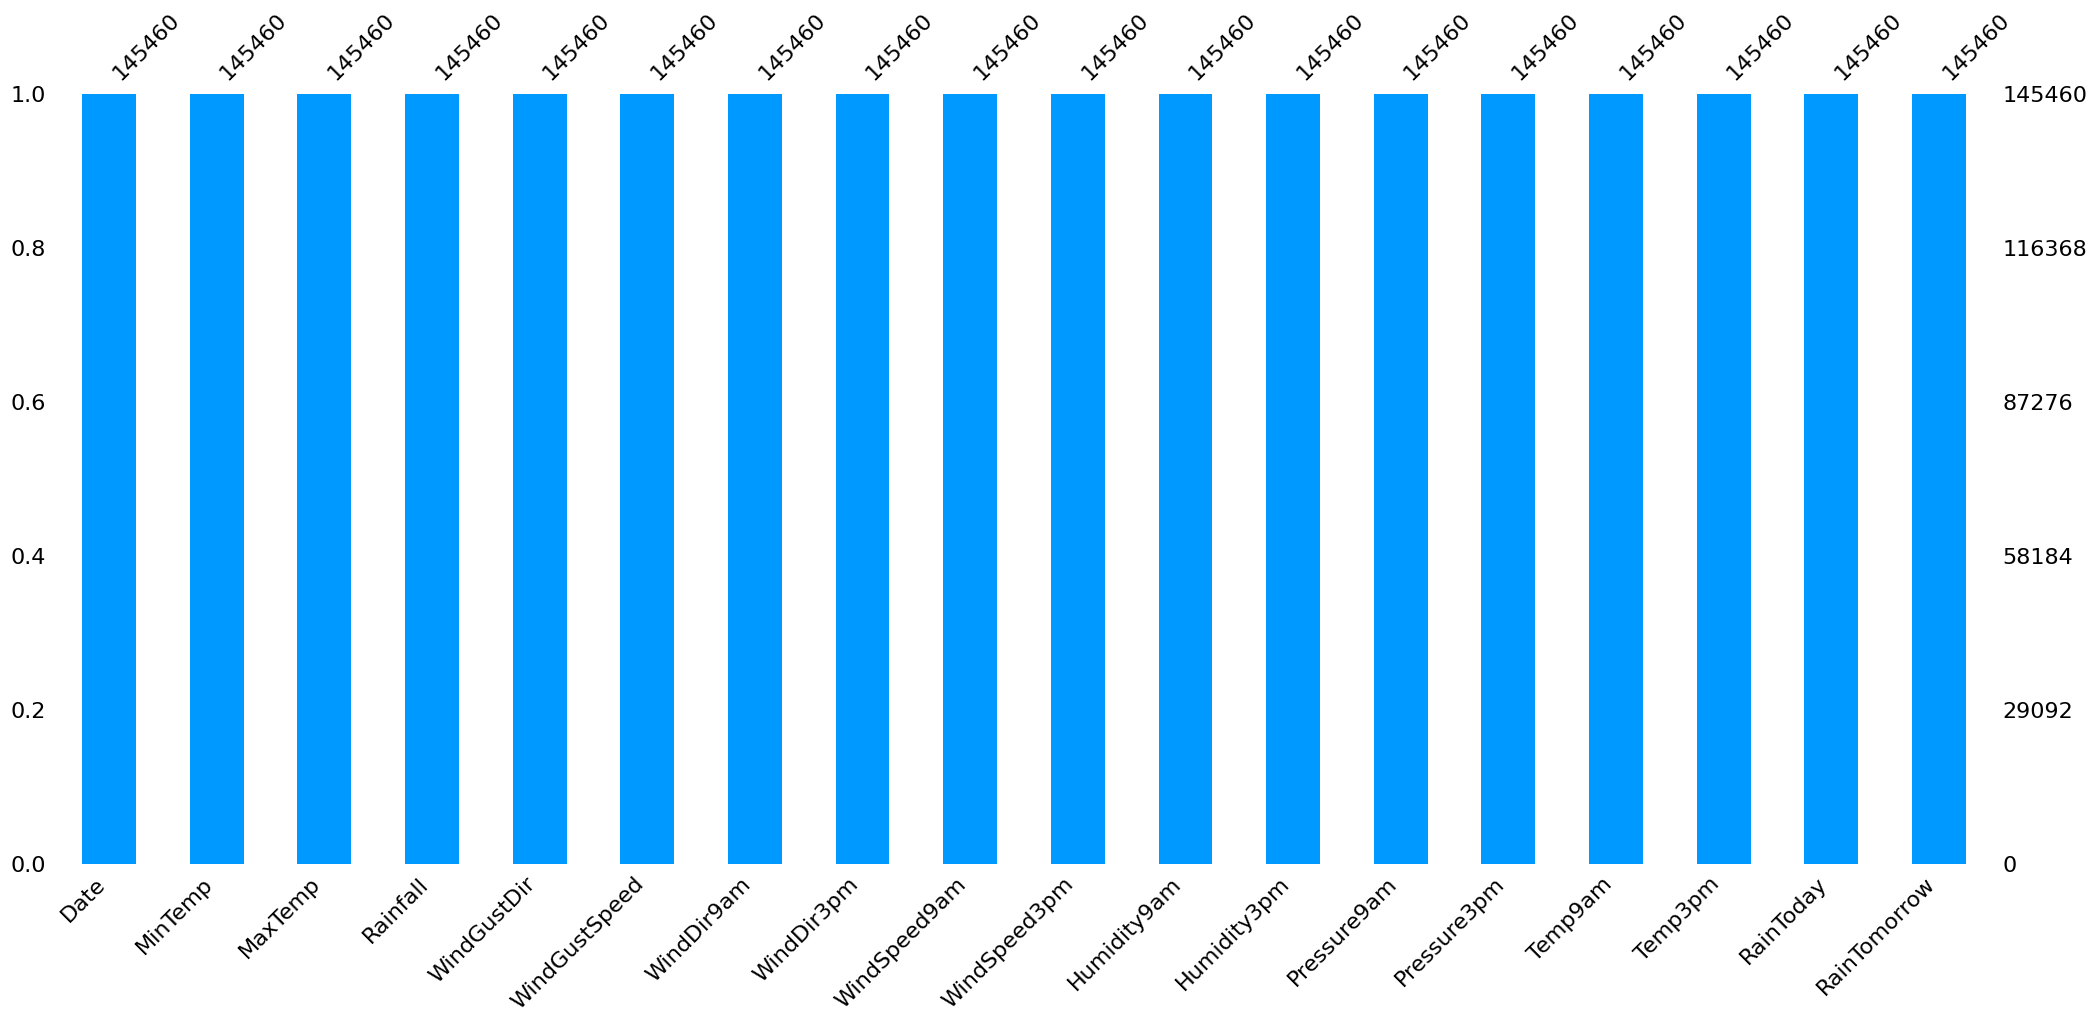

In [29]:
# Filling null values

def fill_na(info):
    cols=info.columns
    for col in cols:
        if info[col].dtype=='object':
            info[col].fillna(method='ffill',inplace=True)
        else:
            info[col].fillna(info[col].median(),inplace=True)
    return info
cleaned_data=fill_na(data)
msno.bar(cleaned_data,color='#0099ff')

In [30]:
train_data,test_data=train_test_split(cleaned_data,test_size=0.1,random_state=40)

In [31]:
categorical=[]
numerical_cols=[]
for col in cleaned_data.columns:
    if cleaned_data[col].dtype=='object':
        categorical.append(col)
    else:
        numerical_cols.append(col)
categorical

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [34]:
import plotly.express as px

for i in range(3):
    category = categorical[i]
    value_counts = train_data[category].value_counts()
    
    fig = px.pie(
        names=value_counts.index,
        values=value_counts.values,
        hole=0.3,
        title=f'{category}'
    )
    fig.show()


In [36]:
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

# Label encoding for WindGustDir
direction_encoder = LabelEncoder()
train_data['WindGustDir'] = direction_encoder.fit_transform(train_data['WindGustDir'])
test_data['WindGustDir'] = direction_encoder.transform(test_data['WindGustDir'])

# Encode the next two categorical features
for col in categorical[1:3]:
    encoder = LabelEncoder()
    train_data[col] = encoder.fit_transform(train_data[col])
    test_data[col] = encoder.transform(test_data[col])

# Bar chart for RainToday
rain_today_counts = train_data['RainToday'].value_counts().reset_index()
rain_today_counts.columns = ['RainToday', 'Count']

fig = px.bar(
    data_frame=rain_today_counts,
    x='RainToday',
    y='Count',
    color='RainToday',
    title='Will it rain today?'
)
fig.show()


In [38]:
import plotly.express as px

# Count values for 'RainTomorrow'
rain_tomorrow_counts = train_data['RainTomorrow'].value_counts().reset_index()
rain_tomorrow_counts.columns = ['RainTomorrow', 'Count']

# Plot bar chart
fig = px.bar(
    data_frame=rain_tomorrow_counts,
    x='RainTomorrow',
    y='Count',
    color='RainTomorrow',
    title='Will it rain tomorrow?'
)
fig.show()


In [39]:
numerical_cols

['Date',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

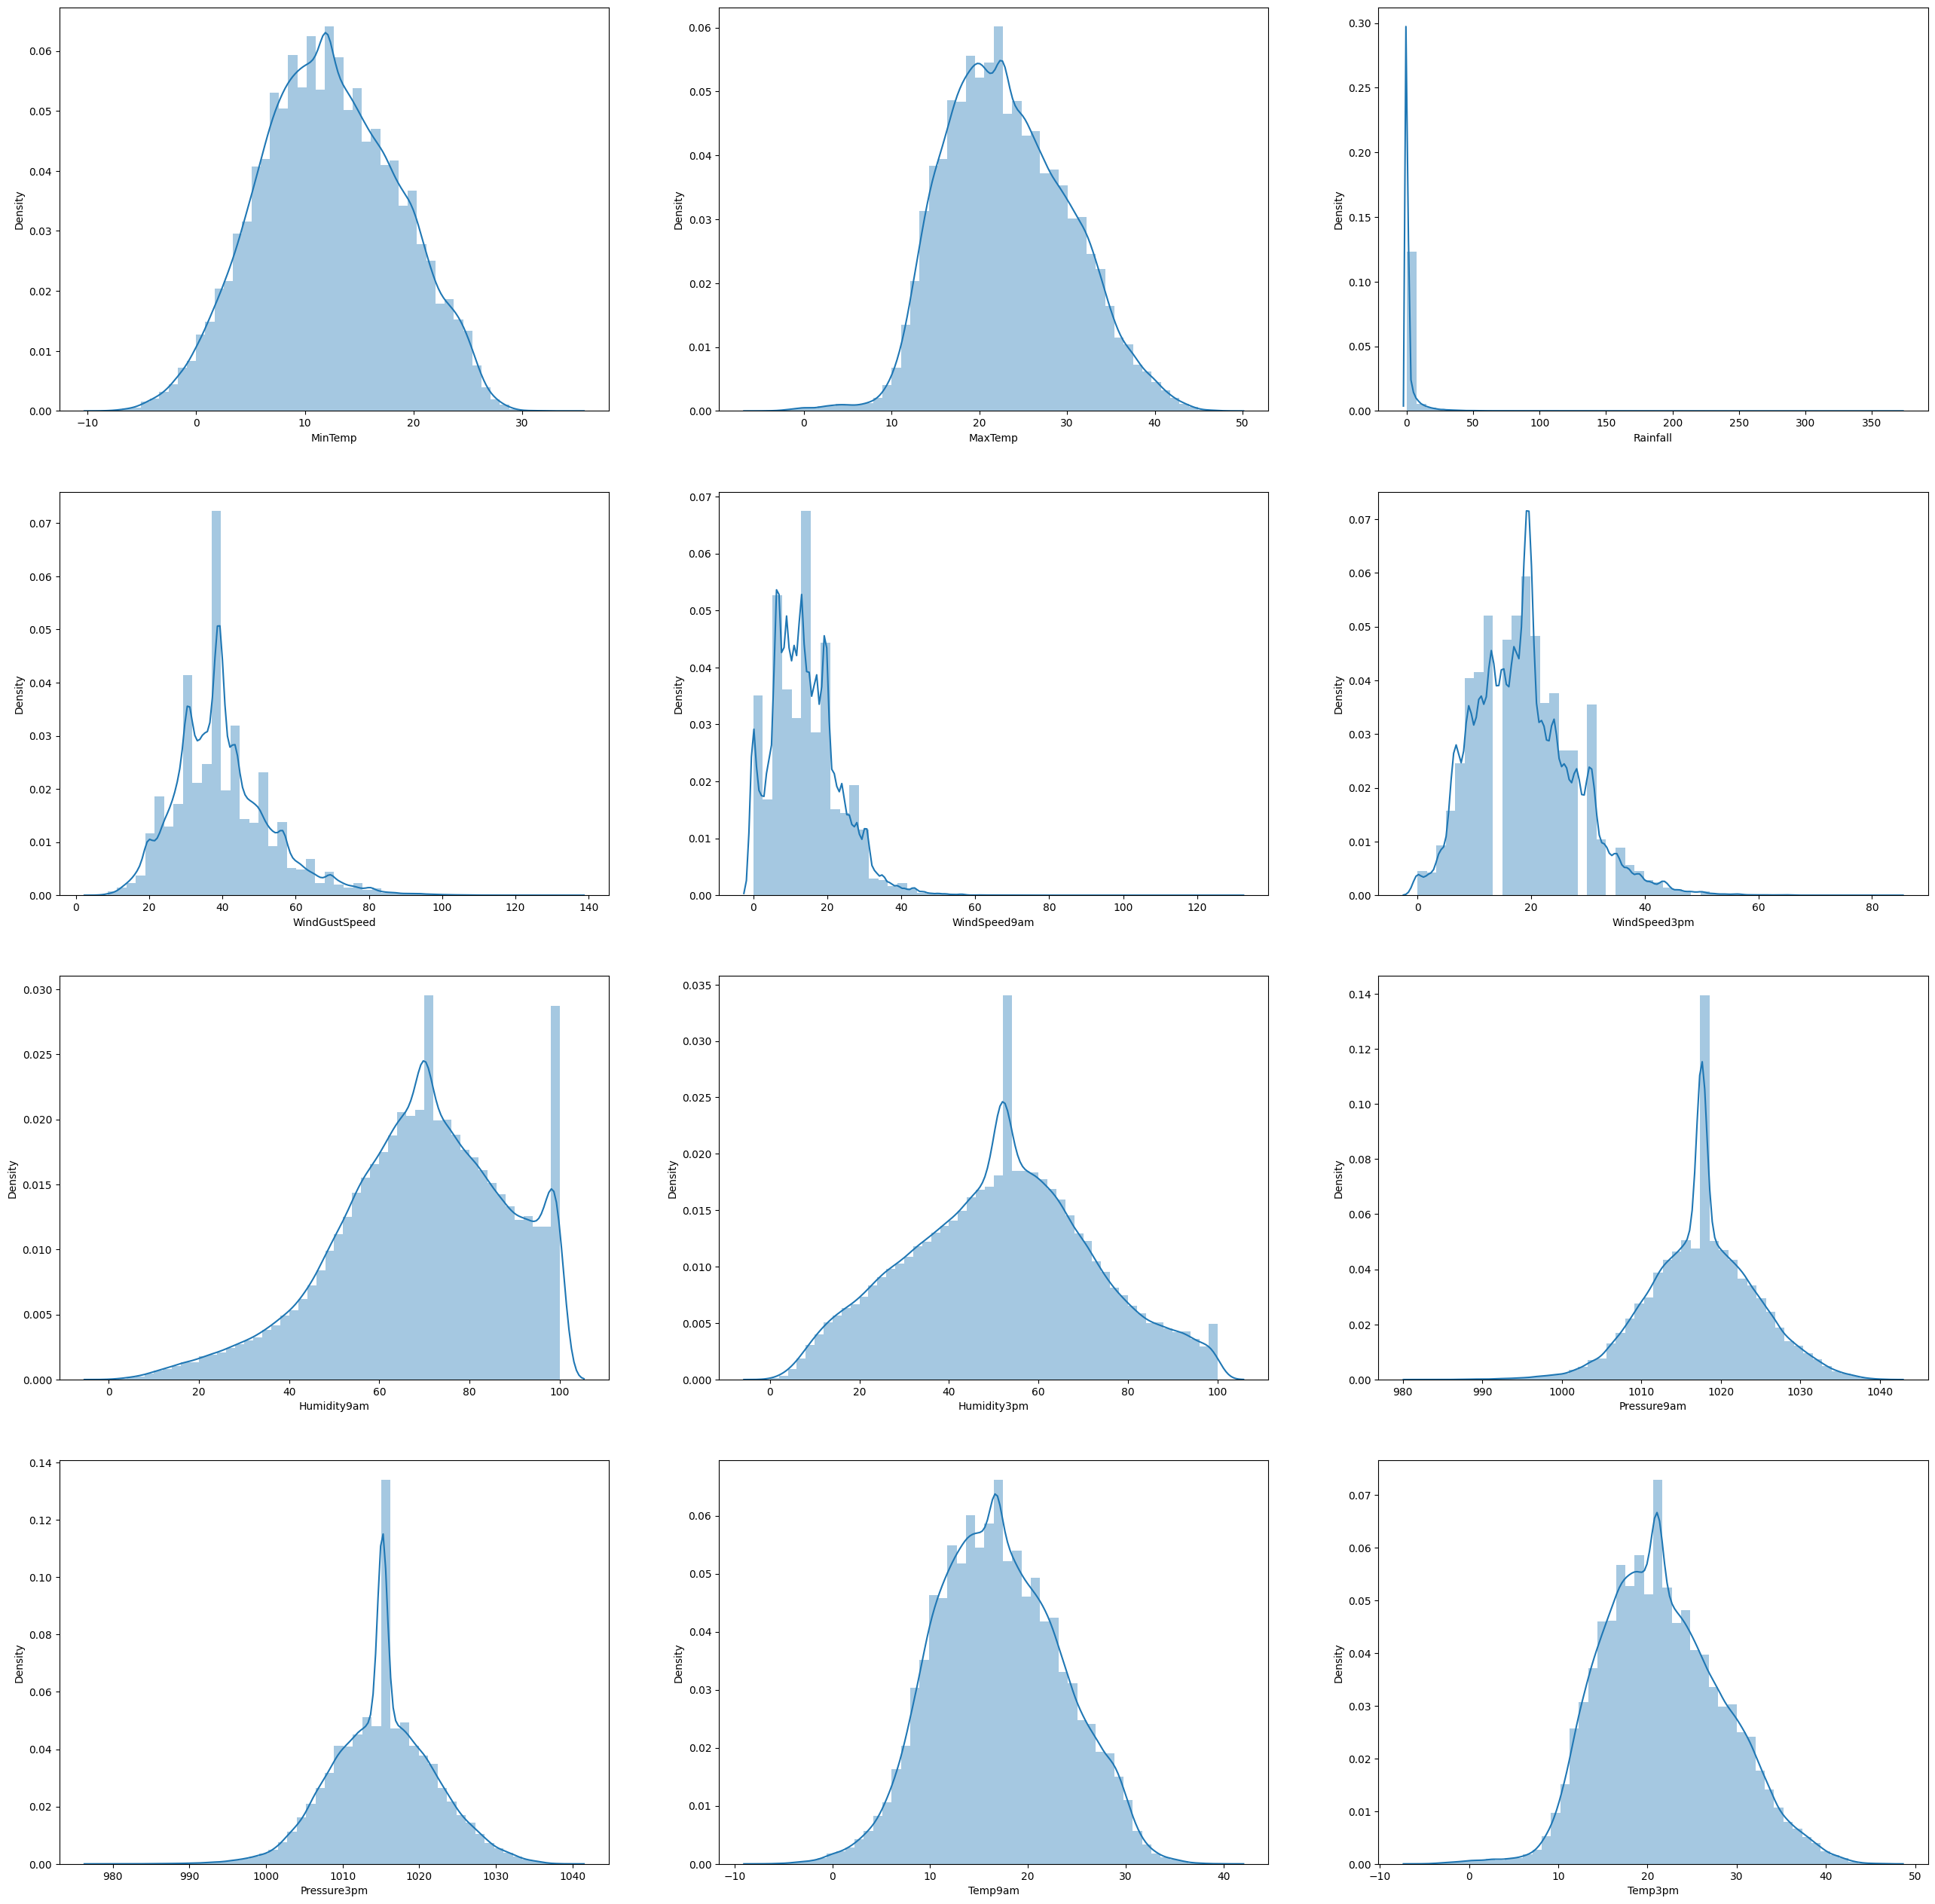

In [40]:
plt.figure(figsize=(32,32))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    sns.distplot(train_data[numerical_cols[i+1]])
plt.show()

In [41]:
train_data.describe()

,Date,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,130914,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000,130914.000000
mean,2013-04-04 13:48:28.015949312,12.188466,23.209612,2.328277,7.979315,39.963625,7.331202,7.815398,14.037177,18.672785,68.918534,51.573949,1017.643549,1015.249166,16.982327,21.663550
min,2007-11-01 00:00:00,-8.500000,-4.800000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,982.000000,978.200000,-7.200000,-5.400000
25%,2011-01-10 00:00:00,7.700000,18.000000,0.000000,4.000000,31.000000,3.000000,4.000000,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.100000,12.300000,16.700000
50%,2013-06-02 00:00:00,12.000000,22.600000,0.000000,8.000000,39.000000,7.000000,8.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,16.700000,21.100000
75%,2015-06-14 00:00:00,16.800000,28.200000,0.600000,12.000000,46.000000,11.000000,12.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,21.500000,26.200000
max,2017-06-25 00:00:00,33.900000,48.100000,371.000000,15.000000,135.000000,15.000000,15.000000,130.000000,83.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000
std,NaN,6.364652,7.084154,8.452890,4.684722,13.122758,4.522439,4.590758,8.864690,8.712646,18.867295,20.474314,6.734109,6.669057,6.447796,6.845808


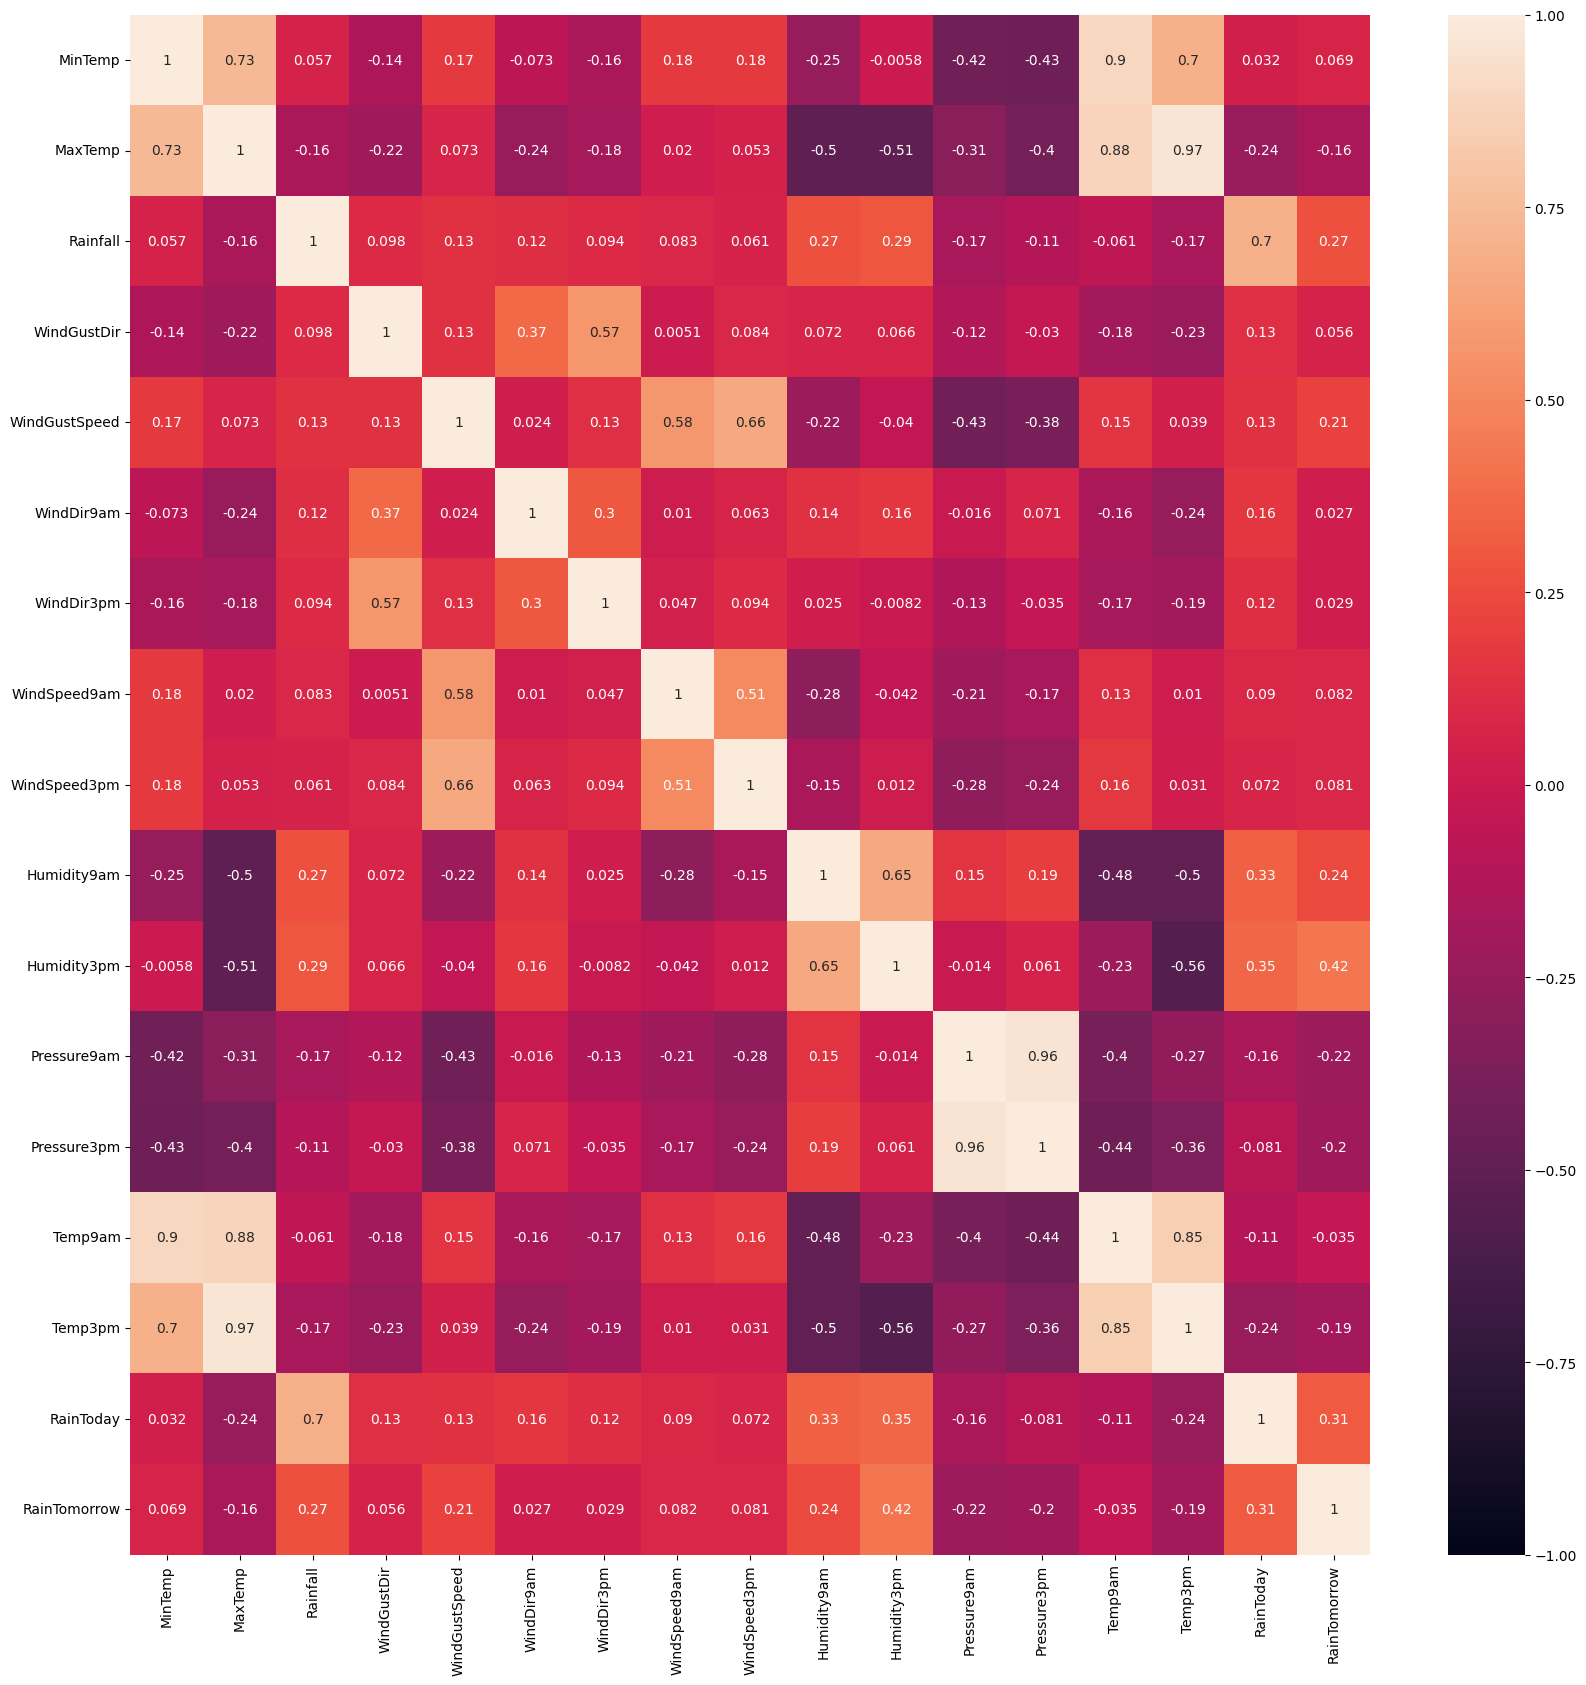

In [42]:
# Removing rows with zscore of Rainfall greater than 3 or less than -3.

cleaned_train_data=train_data[abs(zscore(train_data.Rainfall))<3]
prediction_encoder=LabelEncoder()
cleaned_train_data.RainToday=prediction_encoder.fit_transform(cleaned_train_data.RainToday)
cleaned_train_data.RainTomorrow=prediction_encoder.transform(cleaned_train_data.RainTomorrow)
test_data.RainToday=prediction_encoder.transform(test_data.RainToday)
test_data.RainTomorrow=prediction_encoder.transform(test_data.RainTomorrow)
cleaned_train_data.drop(['Date'],axis=1,inplace=True)
# from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(20,20))
sns.heatmap(cleaned_train_data.corr(),annot=True,vmin=-1)
plt.show()

In [43]:
cleaned_train_data.drop(['MinTemp','MaxTemp','Temp9am','Pressure3pm'],inplace=True,axis=1)
test_data.drop(['MinTemp','MaxTemp','Temp9am','Pressure3pm','Date'],inplace=True,axis=1)

In [45]:
# Splitting the features and labels for training and testing
train_x = train_inputs.iloc[:, :11]  # Features (first 11 columns)
train_y1 = train_output  # Assuming train_output is already defined
train_y2 = train_inputs.iloc[:, 11]  # Label for the 12th column in train_inputs

test_x = test_data.iloc[:, :11]  # Features (first 11 columns)
test_y1 = test_data.iloc[:, 11]  # Label for the 12th column in test_data
test_y2 = test_data.iloc[:, 12]  # Label for the 13th column in test_data


In [46]:
train_x,train_y1,train_y2=train_inputs.iloc[:,:11],train_output,train_inputs.iloc[:,11]
test_x,test_y1,test_y2=test_data.iloc[:,:11],test_data.iloc[:,11],test_data.iloc[:,12]

Βήμα 2: Επιλογή Μοντέλου και Χρήση Λογιστικής Παλινδρόμησης (Logistic Regression)
Η λογιστική παλινδρόμηση είναι ένα από τα πιο δημοφιλή μοντέλα για ταξινόμηση (classification), ειδικά όταν η εξαρτημένη μεταβλητή είναι δυαδική, όπως το RainTomorrow (Ναι/Όχι). Στην περίπτωση αυτή, προσπαθούμε να προβλέψουμε αν θα βρέξει την επόμενη μέρα, με δυαδική έξοδο (0 = "Δεν βρέχει", 1 = "Βρέχει").

Η λογιστική παλινδρόμηση είναι κατάλληλη για ταξινόμηση όταν έχουμε ένα ή περισσότερα χαρακτηριστικά (features) και η έξοδος είναι δυαδική.



In [47]:
modelLR=LogisticRegression()
modelLR.fit(train_x,train_y1)

LogisticRegression()

Εξήγηση των Βημάτων:
1. Προετοιμασία των Δεδομένων
Χαρακτηριστικά (X): Επιλέγουμε τις πρώτες 11 στήλες του DataFrame ως χαρακτηριστικά (features). Αυτές οι στήλες περιλαμβάνουν διάφορες καιρικές παραμέτρους όπως θερμοκρασία, υγρασία, ταχύτητα ανέμου κλπ.

Στόχος (y): Ο στόχος μας είναι η στήλη RainTomorrow, η οποία είναι η κατηγορική μεταβλητή που προσπαθούμε να προβλέψουμε (1 = "Ναι", 0 = "Όχι").

Κωδικοποίηση: Η στήλη RainTomorrow είναι κατηγορική και την κωδικοποιούμε σε αριθμητική μορφή (0 και 1) με τη βοήθεια του LabelEncoder.

Κανονικοποίηση: Ορισμένα μοντέλα, όπως η λογιστική παλινδρόμηση, επωφελούνται από την κανονικοποίηση των δεδομένων (χρησιμοποιούμε StandardScaler).

Διαχωρισμός: Χωρίζουμε τα δεδομένα σε εκπαιδευτικό και δοκιμαστικό σύνολο (80% train, 20% test) με την train_test_split.

2. Εκπαίδευση του Μοντέλου
Δημιουργούμε το μοντέλο LogisticRegression() και το εκπαιδεύουμε με τα δεδομένα εκπαίδευσης X_train και y_train.

Στη συνέχεια, κάνουμε προβλέψεις για το σύνολο δοκιμής με την μέθοδο predict().

3. Αξιολόγηση του Μοντέλου
Ακρίβεια (accuracy): Μετράμε την ακρίβεια του μοντέλου, δηλαδή πόσες προβλέψεις ήταν σωστές.

Confusion Matrix: Παρουσιάζει τα αποτελέσματα της ταξινόμησης με την κατανομή των σωστών και λανθασμένων προβλέψεων.

Classification Report: Περιλαμβάνει μετρικές όπως precision, recall, f1-score για κάθε κλάση (Ναι/Όχι).



In [48]:
print('Classification Report on training data\n',classification_report(train_y1,modelLR.predict(train_x)))
print('Classification Report on validation data\n',classification_report(test_y1,modelLR.predict(test_x)))

Classification Report on training data
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    101341
           1       0.98      0.98      0.98    101341

    accuracy                           0.98    202682
   macro avg       0.98      0.98      0.98    202682
weighted avg       0.98      0.98      0.98    202682

Classification Report on validation data
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     11357
           1       0.94      0.97      0.96      3189

    accuracy                           0.98     14546
   macro avg       0.97      0.98      0.97     14546
weighted avg       0.98      0.98      0.98     14546



In [49]:
print('Train Accuracy of Logistic Regression model is {0} %'.format((accuracy_score(train_y1,modelLR.predict(train_x))*100).round(2)))
print('Validation Accuracy of Logistic Regression is {0} %'.format((accuracy_score(test_y1,modelLR.predict(test_x))*100).round(2)))

Train Accuracy of Logistic Regression model is 98.0 %
Validation Accuracy of Logistic Regression is 98.07 %


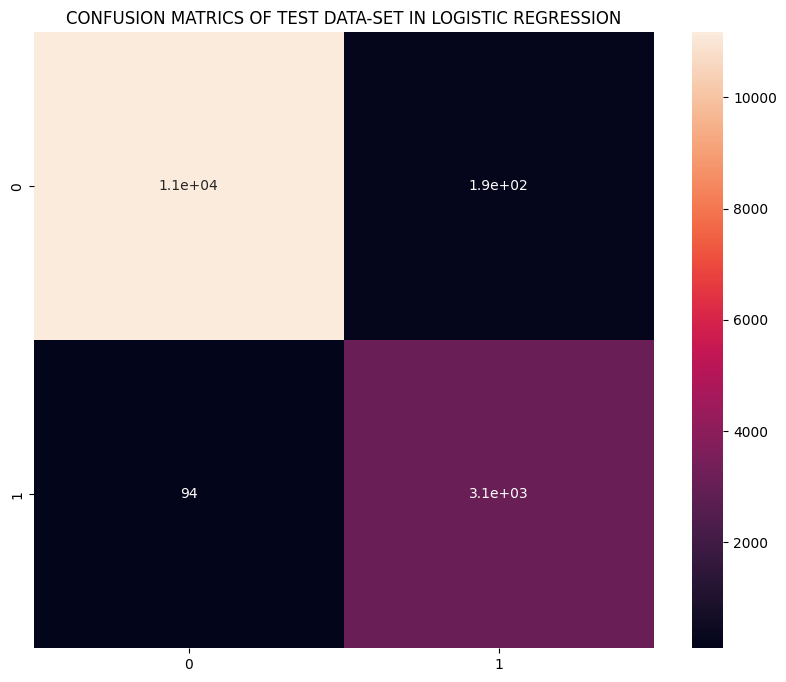

In [50]:
plt.figure(figsize=(10,8))
plt.title('CONFUSION MATRICS OF TEST DATA-SET IN LOGISTIC REGRESSION')
sns.heatmap(confusion_matrix(test_y1,modelLR.predict(test_x)),annot=True)
plt.show()

Χρήση του XGBClassifier για ταξινόμηση
Ο XGBClassifier (XGBoost) είναι ένα από τα πιο ισχυρά και αποτελεσματικά μοντέλα για ταξινόμηση και είναι ιδιαίτερα δημοφιλές για προβλήματα που περιλαμβάνουν πολύπλοκες σχέσεις στα δεδομένα. Χρησιμοποιεί Boosting για να ενισχύσει τη δύναμη των αδύναμων μοντέλων και να παράγει ένα ισχυρό τελικό μοντέλο.

In [51]:
model_xgb=XGBClassifier()
model_xgb.fit(train_x,train_y1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
print('Classification Report on training data\n',classification_report(train_y1,model_xgb.predict(train_x)))
print('Classification Report on validation data\n',classification_report(test_y1,model_xgb.predict(test_x)))

Classification Report on training data
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    101341
           1       1.00      0.99      1.00    101341

    accuracy                           1.00    202682
   macro avg       1.00      1.00      1.00    202682
weighted avg       1.00      1.00      1.00    202682

Classification Report on validation data
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     11357
           1       1.00      0.97      0.98      3189

    accuracy                           0.99     14546
   macro avg       0.99      0.99      0.99     14546
weighted avg       0.99      0.99      0.99     14546



In [53]:
print('Train Accuracy of xgboost model is {0} %'.format((accuracy_score(train_y1,model_xgb.predict(train_x))*100).round(2)))
print('Validation Accuracy of xgboost model is {0} %'.format((accuracy_score(test_y1,model_xgb.predict(test_x))*100).round(2)))

Train Accuracy of xgboost model is 99.51 %
Validation Accuracy of xgboost model is 99.31 %


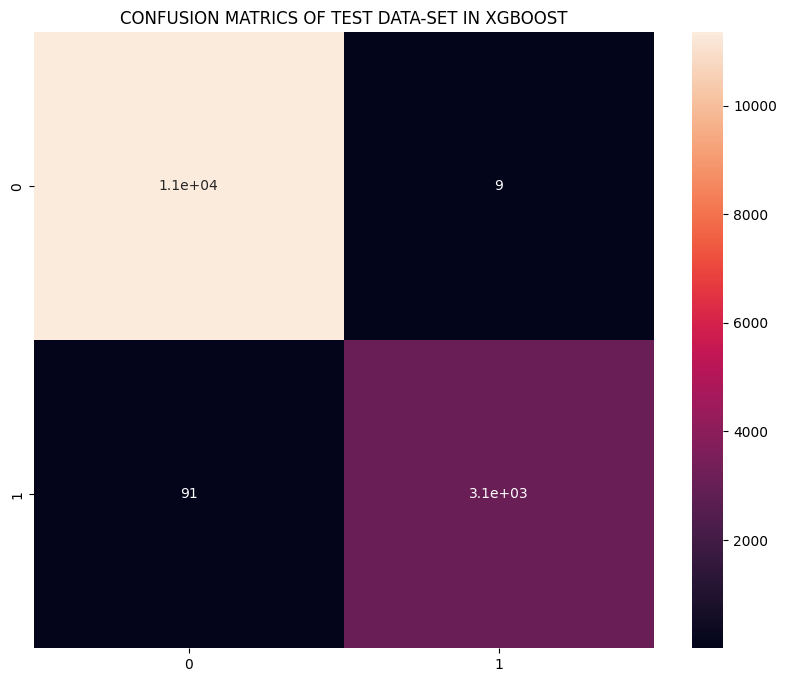

In [54]:
plt.figure(figsize=(10,8))
plt.title('CONFUSION MATRICS OF TEST DATA-SET IN XGBOOST')
sns.heatmap(confusion_matrix(test_y1,model_xgb.predict(test_x)),annot=True)
plt.show()

Χρήση του Random Forest για Ταξινόμηση

Το Random Forest είναι ένα ισχυρό μοντέλο μηχανικής μάθησης που χρησιμοποιεί μια συλλογή (ensemble) από δέντρα απόφασης για να κάνει προβλέψεις. Είναι ιδιαίτερα αποτελεσματικό για ταξινόμηση και προβλήματα παλινδρόμησης. Το Random Forest συνδυάζει τα αποτελέσματα από πολλά δέντρα και μειώνει τη διακύμανση (variance) του μοντέλου

In [55]:
model_random_forest=RandomForestClassifier(max_depth=10)
model_random_forest.fit(train_x,train_y1)

RandomForestClassifier(max_depth=10)

In [56]:
print('Classification Report on training data\n',classification_report(train_y1,model_random_forest.predict(train_x)))
print('Classification Report on validation data\n',classification_report(test_y1,model_random_forest.predict(test_x)))

Classification Report on training data
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    101341
           1       1.00      0.98      0.99    101341

    accuracy                           0.99    202682
   macro avg       0.99      0.99      0.99    202682
weighted avg       0.99      0.99      0.99    202682

Classification Report on validation data
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     11357
           1       1.00      0.97      0.99      3189

    accuracy                           0.99     14546
   macro avg       1.00      0.99      0.99     14546
weighted avg       0.99      0.99      0.99     14546



In [ ]:
print('Train Accuracy of Random forest model is {0} %'.format((accuracy_score(train_y1,model_random_forest.predict(train_x))*100).round(2)))
print('Validation Accuracy of Random forest is {0} %'.format((accuracy_score(test_y1,model_random_forest.predict(test_x))*100).round(2)))

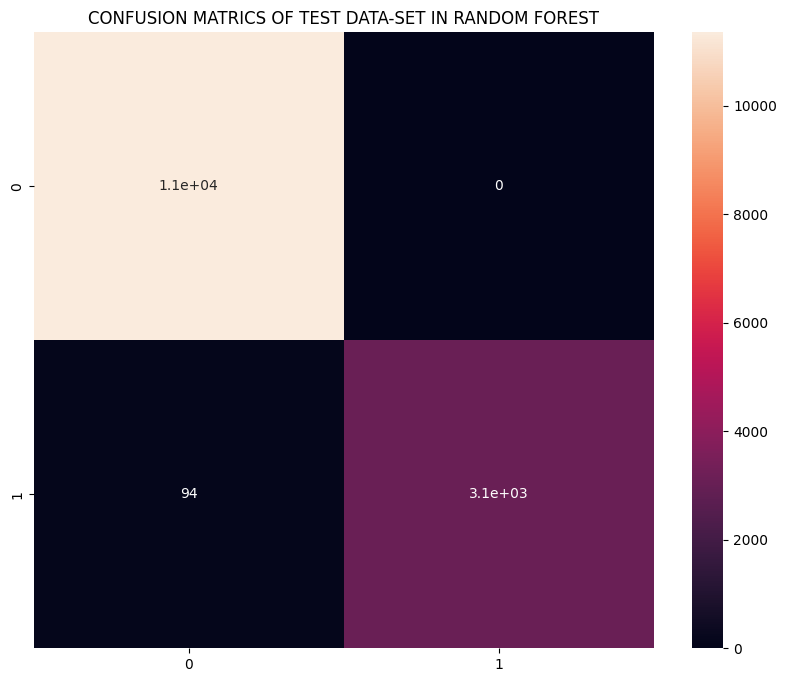

In [57]:
plt.figure(figsize=(10,8))
plt.title('CONFUSION MATRICS OF TEST DATA-SET IN RANDOM FOREST')
sns.heatmap(confusion_matrix(test_y1,model_random_forest.predict(test_x)),annot=True)
plt.show()

Έχουμε δει ότι και τo mοντέλo  λειτούργei αρκετά καλά στην πρόβλεψη του αν θα βρέξει σήμερα, με ακρίβεια περίπου 99,3%